In [1]:
# default_exp moe

# Merit Order Effect Analysis

<br>

### Imports

In [2]:
#exports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pickle
import FEAutils as hlp
from ipypb import track

from moepy import lowess, eda

<br>

### Estimating the Price Surface

In [3]:
%%time

df_EI = eda.load_EI_df('../data/electric_insights.csv')

df_EI.head()

Wall time: 2.13 s


,day_ahead_price,SP,imbalance_price,valueSum,temperature,TCO2_per_h,gCO2_per_kWh,nuclear,biomass,coal,...,demand,pumped_storage,wind_onshore,wind_offshore,belgian,dutch,french,ireland,northern_ireland,irish
local_datetime,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00+00:00,58.05,1,74.74,74.74,-0.6,21278.0,555.0,6.973,0.0,17.650,...,38.329,-0.404,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.161
2009-01-01 00:30:00+00:00,56.33,2,74.89,74.89,-0.6,21442.0,558.0,6.968,0.0,17.770,...,38.461,-0.527,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:00:00+00:00,52.98,3,76.41,76.41,-0.6,21614.0,569.0,6.970,0.0,18.070,...,37.986,-1.018,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:30:00+00:00,50.39,4,37.73,37.73,-0.6,21320.0,578.0,6.969,0.0,18.022,...,36.864,-1.269,NaN,NaN,0.0,0.0,1.746,0.0,0.0,-0.160
2009-01-01 02:00:00+00:00,48.70,5,59.00,59.00,-0.6,21160.0,585.0,6.960,0.0,17.998,...,36.180,-1.566,NaN,NaN,0.0,0.0,1.730,0.0,0.0,-0.160


Text(0, 0.5, 'Price (£/MWh)')

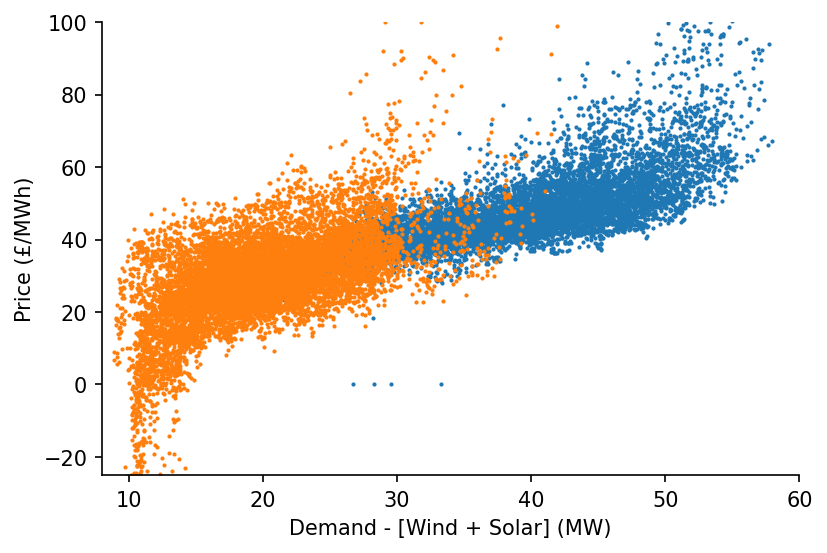

In [4]:
df_EI_model = df_EI[['day_ahead_price', 'demand', 'solar', 'wind']].dropna()

s_price = df_EI_model['day_ahead_price']
s_dispatchable = df_EI_model['demand'] - df_EI_model[['solar', 'wind']].sum(axis=1)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(s_dispatchable['2010-09':'2011-03'], s_price['2010-09':'2011-03'], s=1)
ax.scatter(s_dispatchable['2020-03':'2020-09'], s_price['2020-03':'2020-09'], s=1)

hlp.hide_spines(ax)
ax.set_xlim(8, 60)
ax.set_ylim(-25, 100)
ax.set_xlabel('Demand - [Wind + Solar] (MW)')
ax.set_ylabel('Price (£/MWh)')

In [5]:
%%time

model_fp = '../data/models/weekly_price_curve.pkl'
load_existing_model = False

if load_existing_model == False:
    smooth_dates = pickle.load(open(model_fp, 'rb'))
else:
    reg_dates = pd.date_range('2009-01-01', '2021-01-01', freq='13W')

    smooth_dates = lowess.SmoothDates()
    smooth_dates.fit(s_dispatchable.values, s_price.values, dt_idx=s_dispatchable.index, 
                     reg_dates=reg_dates, frac=0.3, num_fits=31, threshold_value=26)
    
    pickle.dump(smooth_dates, open(model_fp, 'wb'))

 [████████████████████████████████████████████████████████████] 49/49 [05:46<00:06, 7.05s/it]

c:\users\ayrto\desktop\phd\analysis\merit-order-effect\moepy\lowess.py:239: RuntimeWarning: invalid value encountered in true_divide
  loading_weights = loading_weights/loading_weights.sum(axis=0) # normalising


Wall time: 5min 54s


In [6]:
%%time

x_pred = np.linspace(8, 60, 53)
dt_pred = pd.date_range('2009-01-01', '2021-01-01', freq='1W')

df_pred = smooth_dates.predict(x_pred=x_pred, dt_pred=dt_pred)

df_pred.head()

Wall time: 365 ms


,2009-01-04,2009-01-11,2009-01-18,2009-01-25,2009-02-01,2009-02-08,2009-02-15,2009-02-22,2009-03-01,2009-03-08,...,2020-10-25,2020-11-01,2020-11-08,2020-11-15,2020-11-22,2020-11-29,2020-12-06,2020-12-13,2020-12-20,2020-12-27
8.0,-8.944939,-9.027980,-9.104211,-9.173215,-9.234846,-9.289196,-9.336549,-9.377344,-9.412134,-9.441560,...,6.896797,6.942995,6.988624,7.033736,7.078473,7.123097,7.168043,7.213979,7.261883,7.312838
9.0,-6.992483,-7.071627,-7.144280,-7.210040,-7.268766,-7.320542,-7.365640,-7.404475,-7.437578,-7.465556,...,9.338424,9.384932,9.431004,9.476690,9.522115,9.567522,9.613318,9.660129,9.708880,9.760598
10.0,-5.040274,-5.115529,-5.184611,-5.247134,-5.302963,-5.352176,-5.395028,-5.431916,-5.463342,-5.489886,...,11.784039,11.830936,11.877533,11.923869,11.970061,12.016329,12.063051,12.110814,12.160491,12.213053
11.0,-3.089047,-3.160482,-3.226061,-3.285418,-3.338422,-3.385146,-3.425832,-3.460856,-3.490695,-3.515896,...,14.253323,14.300689,14.347891,14.394960,14.441999,14.489210,14.536940,14.585738,14.636426,14.689918
12.0,-1.138795,-1.206425,-1.268519,-1.324727,-1.374926,-1.419186,-1.457733,-1.490924,-1.519208,-1.543104,...,16.738686,16.786654,16.834592,16.882525,16.930542,16.978824,17.027690,17.077653,17.129483,17.184041


<br>

### Visualising the Price Surface

Text(0.5, 1.0, 'Day-Ahead Mkt Price Curve Estimate')

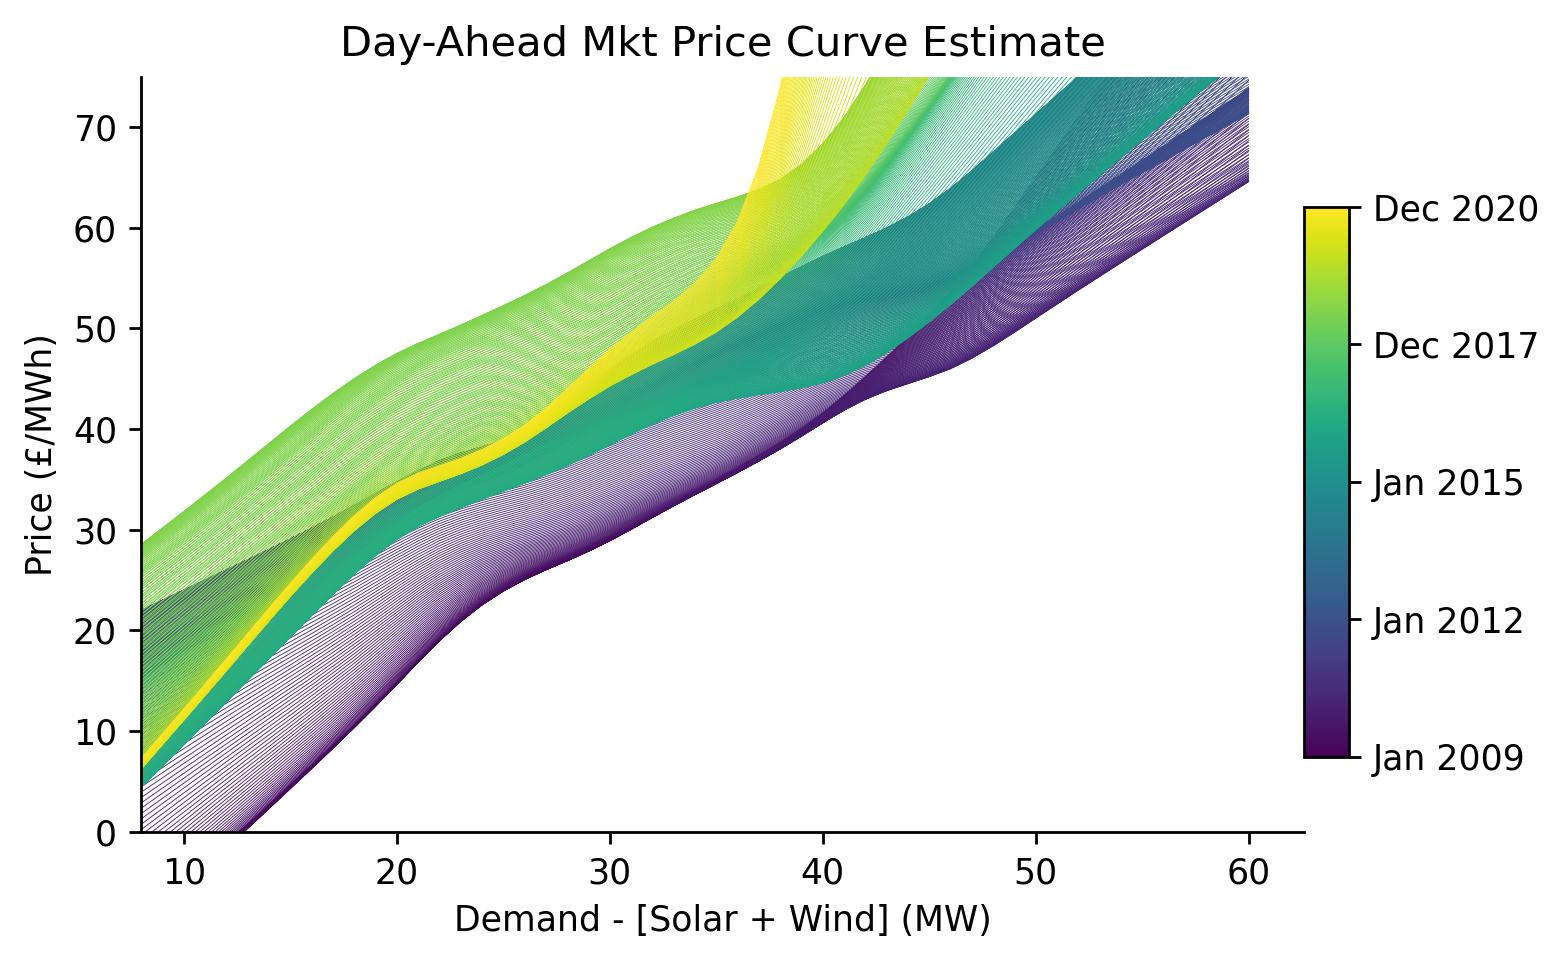

In [15]:
cmap = plt.get_cmap('viridis')
cbar_ticks = [0, 0.25, 0.5, 0.75, 1]

# Plotting
fig, ax = plt.subplots(dpi=250)

lp = df_pred.plot(legend=False, cmap=cmap, linewidth=0.25, ax=ax)

cax = fig.add_axes([0.9, 0.2, 0.03, 0.55])
cbar = mpl.colorbar.ColorbarBase(cax, orientation='vertical', cmap=cmap, ticks=cbar_ticks)
cbar.ax.set_yticklabels([dt_pred[min(int(len(dt_pred)*tick_loc), len(dt_pred)-1)].strftime('%b %Y') for tick_loc in cbar_ticks])

hlp.hide_spines(ax)
ax.set_xlabel('Demand - [Solar + Wind] (MW)')
ax.set_ylabel('Price (£/MWh)')
ax.set_xlim(df_pred.index[0])
ax.set_ylim(0, 75)
ax.set_title('Day-Ahead Mkt Price Curve Estimate')

<AxesSubplot:>

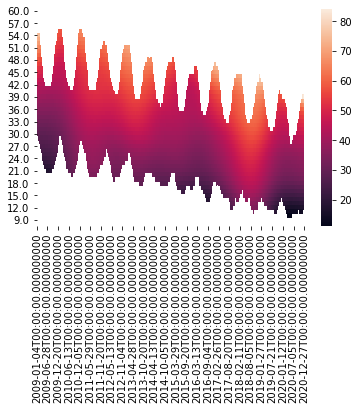

In [33]:
rolling_w = 10

df_dispatchable_lims = (s_dispatchable
                        .resample('1W')
                        .quantile([0.001, 0.999])
                        .unstack()
                        .rolling(rolling_w)
                        .mean()
                        .shift(int(-rolling_w/2))
                        .bfill()
                        .ffill()
                        .iloc[:-1, :]
                       )

df_pred_mask = pd.DataFrame(dict(zip(df_pred.columns, [df_pred.index]*df_pred.shape[1])), index=df_pred.index)
df_pred_mask = (df_pred_mask > df_dispatchable_lims.iloc[:, 0].values) & (df_pred_mask < df_dispatchable_lims.iloc[:, 1].values)

sns.heatmap(df_pred.where(df_pred_mask, np.nan).iloc[::-1])

Text(0.5, 1.0, 'Day-Ahead Mkt Price Curve Estimate')

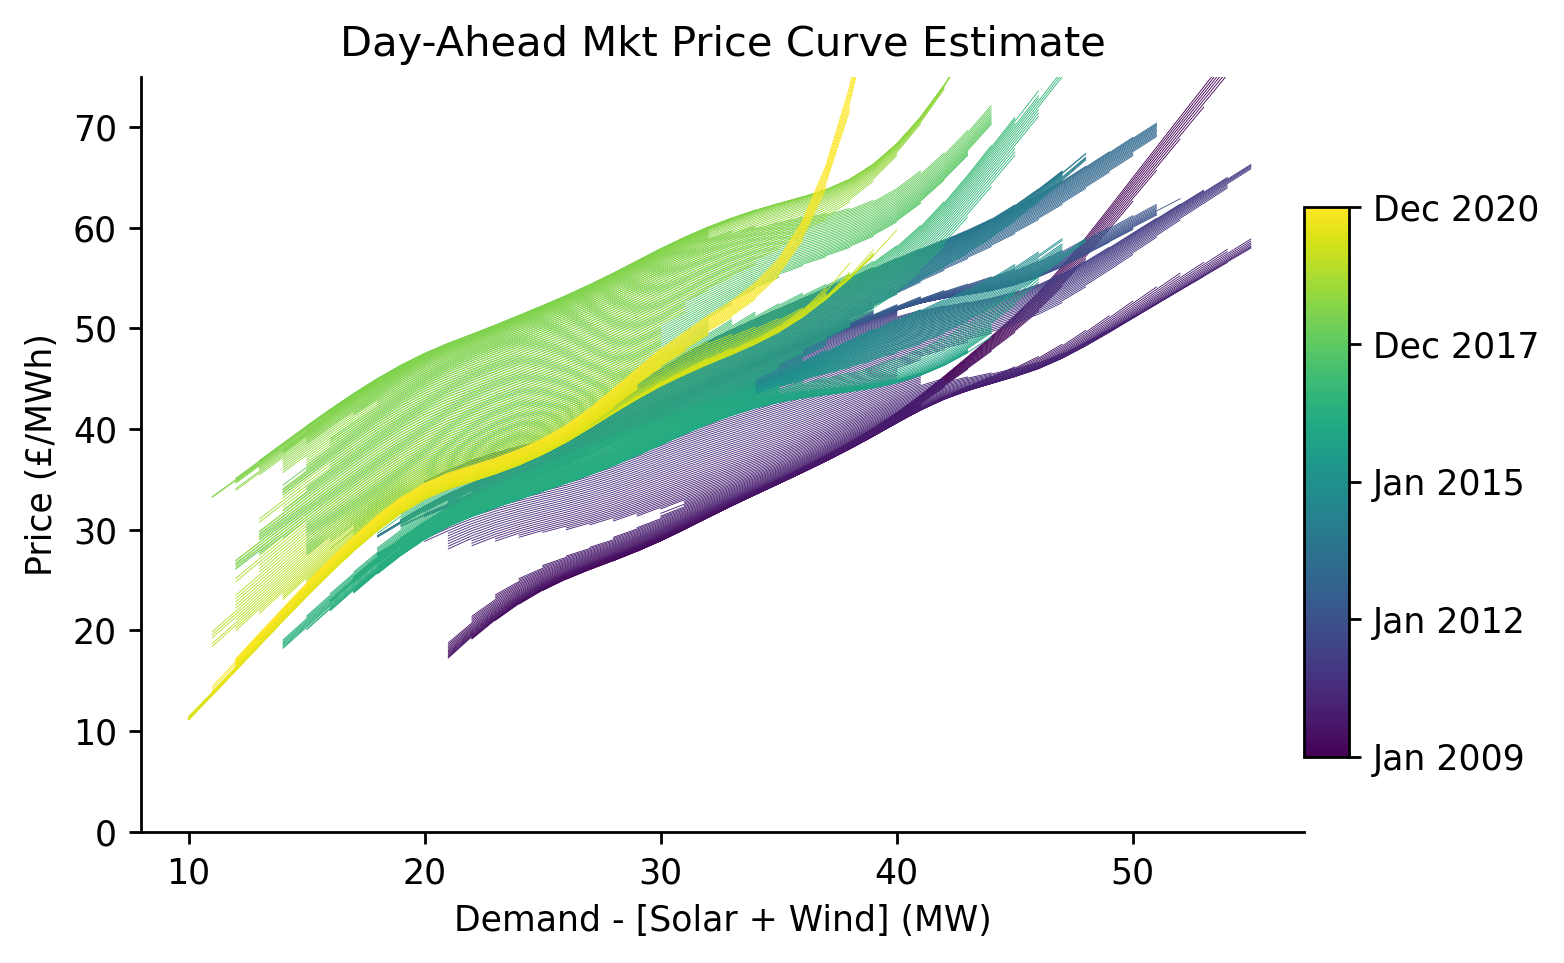

In [34]:
cmap = plt.get_cmap('viridis')
cbar_ticks = [0, 0.25, 0.5, 0.75, 1]

# Plotting
fig, ax = plt.subplots(dpi=250)

lp = df_pred.where(df_pred_mask, np.nan).plot(legend=False, cmap=cmap, linewidth=0.25, ax=ax)

cax = fig.add_axes([0.9, 0.2, 0.03, 0.55])
cbar = mpl.colorbar.ColorbarBase(cax, orientation='vertical', cmap=cmap, ticks=cbar_ticks)
cbar.ax.set_yticklabels([dt_pred[min(int(len(dt_pred)*tick_loc), len(dt_pred)-1)].strftime('%b %Y') for tick_loc in cbar_ticks])

hlp.hide_spines(ax)
ax.set_xlabel('Demand - [Solar + Wind] (MW)')
ax.set_ylabel('Price (£/MWh)')
ax.set_xlim(df_pred.index[0])
ax.set_ylim(0, 75)
ax.set_title('Day-Ahead Mkt Price Curve Estimate')

C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


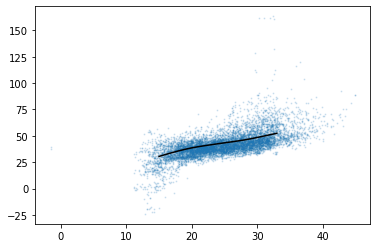

In [35]:
s_pred = df_pred.where(df_pred_mask, np.nan).iloc[:, 450]

dt_min = s_pred.name - pd.Timedelta(weeks=12)
dt_max = s_pred.name + pd.Timedelta(weeks=12)

plt.scatter(s_dispatchable[dt_min:dt_max], s_price[dt_min:dt_max], s=1, alpha=0.15)
plt.plot(s_pred, color='k')

In [36]:
# Need to work out how often values fall outside the mask when looking at the full ts, should be ~2%
# would be cool to have a gif where each frame is the addition of a new week
# Connect the estimated curves so it looks like its being drawn as a single line

In [37]:
#hide
from nbdev.export import *
notebook2script()

Converted 01-retrieval.ipynb.
Converted 02-eda.ipynb.
Converted 03-lowess.ipynb.
Converted 04-merit-order-effect.ipynb.
